In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import batman, catwoman
from multiprocessing import Pool
import emcee


In [2]:
## some useful conversions
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

## handy calculations
def calc_impact_param(a_over_Rstar, inc):
    # assumes a circular orbit
    # Inputs:
    # a_over_Rstar = orbital semi-major-axis in units of stellar radii
    # inc = orbital inclination in [degrees]
    b = a_over_Rstar*np.cos(np.deg2rad(inc))
    return b
    
## functions to measure the points of transit contact
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

## ANALYTIC FUNCTIONS
def predict_dT1(period, semi_maj_axis, impact_param, Rstar, Rmorning, Runiform):
    # Inputs:
    # period = orbital period in any time units, will just become the output unit
    # semi_maj_axis = orbital semi-major-axis in same units as the input radii parameters, as the length units cancel
    # impact_param = orbital impact parameter (w.r.t. stellar equator), unitless
    # Rstar = radius of the star
    # Rmorning = radius of the planet's morning-limb
    # Runiform = radius of the equivalent-depth uniform-limb planet
    prefactor = period / (2.*np.pi*semi_maj_axis)
    term1 = np.sqrt( (Rstar + Rmorning)**2 - (impact_param * Rstar)**2 )
    term2 = np.sqrt( (Rstar + Runiform)**2 - (impact_param * Rstar)**2 )
    calc = prefactor*(term1 - term2)
    return calc

def predict_dT4(period, semi_maj_axis, impact_param, Rstar, Revening, Runiform):
    # same calculation as deltaT1, but replace {Rmorning, Runiform} in dT1 calc with {Runiform, Revening} here
    calc = predict_dT1(period, semi_maj_axis, impact_param, Rstar, Runiform, Revening)
    return calc

def overlap_compensation(Rp_ref, RpRstar, H, N, v_orb):
    ## Computes the expected additional dt that the
    ##   numerical model will use to compensate for
    ##   the overlap problem.
    ## INPUTS:
    ##   Rp_ref = smallest limb radius, in [meter]
    ##   RpRstar = planet-star radius ratio, corresponding to Rp_ref
    ##   H = planetary atmosphere bulk scale height in [meter]
    ##   N = number of scale heights btwn. Rp_ref and larger limb radius
    ##   v_orb = planet's orbital speed in [meters / second]
    ## OUTPUT: the expected compensation in [seconds]
    
    # Compute the x-coordinate i.e. the radius of the larger limb
    x = Rp_ref + (N*H) # [meter]f
    # Compute y i.e. the distance from the planet's central axis
    #   to the stellar disk edge
    y = (Rp_ref/RpRstar) - np.sqrt((Rp_ref/RpRstar)**2 - x**2) # [meter]
    # Convert to the duration of time from ... to ...
    ytime = y / v_orb # [s]
    return ytime

Checking the real cadence, noisy runs for each test planet.

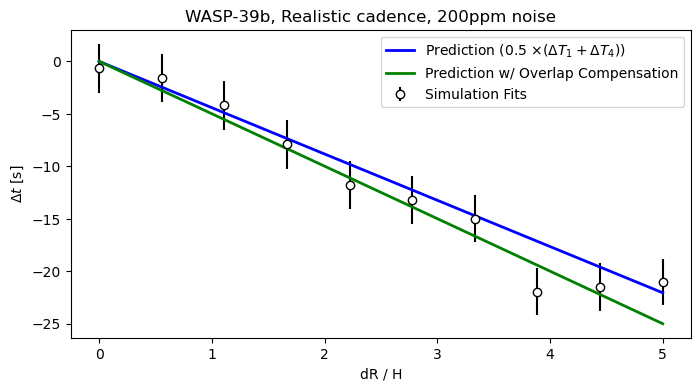

In [3]:
## -- load in numerical results

## -- WASP-39b 
## simulation results
w39_file = './newresults_realcadence_200ppmnoise_wasp39b_uniformLD.npz'
w39_load = np.load(w39_file)
w39_Nvals = w39_load['Nvals']
w39_Hval = w39_load['Hval'] # scale height in [meter]
w39_time = w39_load['time_axis']
w39_true_lightcurves = w39_load['true_lightcurves']
w39_bestfit_lightcurves = w39_load['bestfit_lightcurves']
w39_dt_fits = w39_load['dt_fits']
w39_dt_errs = w39_load['dt_fiterrs']
## planet parameters
w39_period_days = 4.0552941 # [day]
w39_a_Rstar = 11.55         # [stellar (wasp-39) radii]
w39_inc_deg = 87.32         # [degrees]
w39_Rstar_Rsol = 0.92868    # [Rsun]
w39_Rstar_meter = w39_Rstar_Rsol * Rsun_to_meter # [meter]
w39_a_meter = w39_a_Rstar * w39_Rstar_Rsol * Rsun_to_meter
w39_impactparam = calc_impact_param(w39_a_Rstar, w39_inc_deg) # [unitless]
w39_Rpref_meter = 0.1457 * w39_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
w39_Rpeve_vals_meter = w39_Rpref_meter*np.ones(len(w39_Nvals))
w39_dR_vals_meter = w39_Nvals * w39_Hval
w39_Rpmorn_vals_meter = w39_Rpeve_vals_meter + w39_dR_vals_meter
w39_Rpunif_vals_meter = np.sqrt(0.5*(w39_Rpeve_vals_meter**2 + w39_Rpmorn_vals_meter**2))
w39_vorb = (2.*np.pi*w39_a_meter) / (w39_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
w39_predicted_dT1self_vals_sec = predict_dT1(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpmorn_vals_meter, w39_Rpeve_vals_meter)*day_to_second
w39_predicted_dT4self_vals_sec = predict_dT4(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpeve_vals_meter, w39_Rpeve_vals_meter)*day_to_second
w39_predicted_dT1ucase_vals_sec = predict_dT1(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpmorn_vals_meter, w39_Rpunif_vals_meter)*day_to_second
w39_predicted_dT4ucase_vals_sec = predict_dT4(w39_period_days, w39_a_meter, w39_impactparam, w39_Rstar_meter, w39_Rpeve_vals_meter, w39_Rpunif_vals_meter)*day_to_second
w39_predicted_dt = -0.5*(w39_predicted_dT1ucase_vals_sec+w39_predicted_dT4ucase_vals_sec)
w39_overlapcomp_sec = 0.5*overlap_compensation(w39_Rpref_meter, (w39_Rpref_meter/w39_Rstar_meter), w39_Hval, w39_Nvals, w39_vorb)
w39_overlapcomp_sec -= w39_overlapcomp_sec[0]

## plot results
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('WASP-39b, Realistic cadence, 200ppm noise',y=0.93)
ax.errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(w39_Nvals, w39_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(w39_Nvals, w39_predicted_dt-w39_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

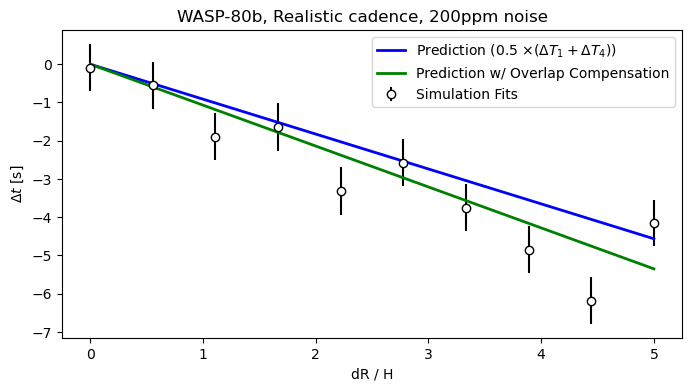

In [4]:
## -- WASP-80b 
## simulation results
w80_file = './newresults_realcadence_200ppmnoise_wasp80b_uniformLD.npz'
w80_load = np.load(w80_file)
w80_Nvals = w80_load['Nvals']
w80_Hval = w80_load['Hval'] # scale height in [meter]
w80_time = w80_load['time_axis']
w80_true_lightcurves = w80_load['true_lightcurves']
w80_bestfit_lightcurves = w80_load['bestfit_lightcurves']
w80_dt_fits = w80_load['dt_fits']
w80_dt_errs = w80_load['dt_fiterrs']
## planet parameters
w80_period_days = 3.06785271 # [day]
w80_a_Rstar = 12.63        # [stellar (wasp-39) radii]
w80_inc_deg = 89.02         # [degrees]
w80_Rstar_Rsol = 0.605    # [Rsun]
w80_Rstar_meter = w80_Rstar_Rsol * Rsun_to_meter # [meter]
w80_a_meter = w80_a_Rstar * w80_Rstar_Rsol * Rsun_to_meter
w80_impactparam = calc_impact_param(w80_a_Rstar, w80_inc_deg) # [unitless]
w80_Rpref_meter = 0.17137 * w80_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
w80_Rpeve_vals_meter = w80_Rpref_meter*np.ones(len(w80_Nvals))
w80_dR_vals_meter = w80_Nvals * w80_Hval
w80_Rpmorn_vals_meter = w80_Rpeve_vals_meter + w80_dR_vals_meter
w80_Rpunif_vals_meter = np.sqrt(0.5*(w80_Rpeve_vals_meter**2 + w80_Rpmorn_vals_meter**2))
w80_vorb = (2.*np.pi*w80_a_meter) / (w80_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
w80_predicted_dT1self_vals_sec = predict_dT1(w80_period_days, w80_a_meter, w80_impactparam, w80_Rstar_meter, w80_Rpmorn_vals_meter, w80_Rpeve_vals_meter)*day_to_second
w80_predicted_dT4self_vals_sec = predict_dT4(w80_period_days, w80_a_meter, w80_impactparam, w80_Rstar_meter, w80_Rpeve_vals_meter, w80_Rpeve_vals_meter)*day_to_second
w80_predicted_dT1ucase_vals_sec = predict_dT1(w80_period_days, w80_a_meter, w80_impactparam, w80_Rstar_meter, w80_Rpmorn_vals_meter, w80_Rpunif_vals_meter)*day_to_second
w80_predicted_dT4ucase_vals_sec = predict_dT4(w80_period_days, w80_a_meter, w80_impactparam, w80_Rstar_meter, w80_Rpeve_vals_meter, w80_Rpunif_vals_meter)*day_to_second
w80_predicted_dt = -0.5*(w80_predicted_dT1ucase_vals_sec+w80_predicted_dT4ucase_vals_sec)
w80_overlapcomp_sec = 0.5*overlap_compensation(w80_Rpref_meter, (w80_Rpref_meter/w80_Rstar_meter), w80_Hval, w80_Nvals, w80_vorb)
w80_overlapcomp_sec -= w80_overlapcomp_sec[0]

## plot results
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('WASP-80b, Realistic cadence, 200ppm noise',y=0.93)
ax.errorbar(w80_Nvals, w80_dt_fits, w80_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(w80_Nvals, w80_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(w80_Nvals, w80_predicted_dt-w80_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

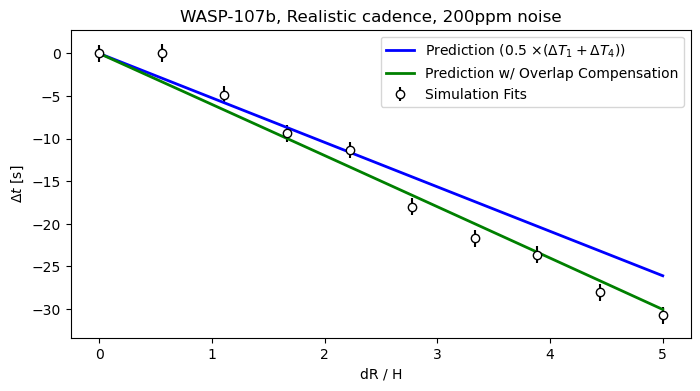

In [5]:
## -- WASP-107b 
## simulation results
w107_file = './newresults_realcadence_200ppmnoise_wasp107b_uniformLD.npz'
w107_load = np.load(w107_file)
w107_Nvals = w107_load['Nvals']
w107_Hval = w107_load['Hval'] # scale height in [meter]
w107_time = w107_load['time_axis']
w107_true_lightcurves = w107_load['true_lightcurves']
w107_bestfit_lightcurves = w107_load['bestfit_lightcurves']
w107_dt_fits = w107_load['dt_fits'] - w107_load['dt_fits'][0]
w107_dt_errs = w107_load['dt_fiterrs']
## planet parameters
w107_period_days = 5.721488 # [day]
w107_a_Rstar = 18.2         # [stellar radii]
w107_inc_deg = 89.7         # [degrees]
w107_Rstar_Rsol = 0.73    # [Rsun]
w107_Rstar_meter = w107_Rstar_Rsol * Rsun_to_meter # [meter]
w107_a_meter = w107_a_Rstar * w107_Rstar_Rsol * Rsun_to_meter
w107_impactparam = calc_impact_param(w107_a_Rstar, w107_inc_deg) # [unitless]
w107_Rpref_meter = 0.14434 * w107_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
w107_Rpeve_vals_meter = w107_Rpref_meter*np.ones(len(w107_Nvals))
w107_dR_vals_meter = w107_Nvals * w107_Hval
w107_Rpmorn_vals_meter = w107_Rpeve_vals_meter + w107_dR_vals_meter
w107_Rpunif_vals_meter = np.sqrt(0.5*(w107_Rpeve_vals_meter**2 + w107_Rpmorn_vals_meter**2))
w107_vorb = (2.*np.pi*w107_a_meter) / (w107_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
w107_predicted_dT1self_vals_sec = predict_dT1(w107_period_days, w107_a_meter, w107_impactparam, w107_Rstar_meter, w107_Rpmorn_vals_meter, w107_Rpeve_vals_meter)*day_to_second
w107_predicted_dT4self_vals_sec = predict_dT4(w107_period_days, w107_a_meter, w107_impactparam, w107_Rstar_meter, w107_Rpeve_vals_meter, w107_Rpeve_vals_meter)*day_to_second
w107_predicted_dT1ucase_vals_sec = predict_dT1(w107_period_days, w107_a_meter, w107_impactparam, w107_Rstar_meter, w107_Rpmorn_vals_meter, w107_Rpunif_vals_meter)*day_to_second
w107_predicted_dT4ucase_vals_sec = predict_dT4(w107_period_days, w107_a_meter, w107_impactparam, w107_Rstar_meter, w107_Rpeve_vals_meter, w107_Rpunif_vals_meter)*day_to_second
w107_predicted_dt = -0.5*(w107_predicted_dT1ucase_vals_sec+w107_predicted_dT4ucase_vals_sec)
w107_overlapcomp_sec = 0.5*overlap_compensation(w107_Rpref_meter, (w107_Rpref_meter/w107_Rstar_meter), w107_Hval, w107_Nvals, w107_vorb)
w107_overlapcomp_sec -= w107_overlapcomp_sec[0]

## plot results
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('WASP-107b, Realistic cadence, 200ppm noise',y=0.93)
ax.errorbar(w107_Nvals, w107_dt_fits, w107_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(w107_Nvals, w107_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(w107_Nvals, w107_predicted_dt-w107_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

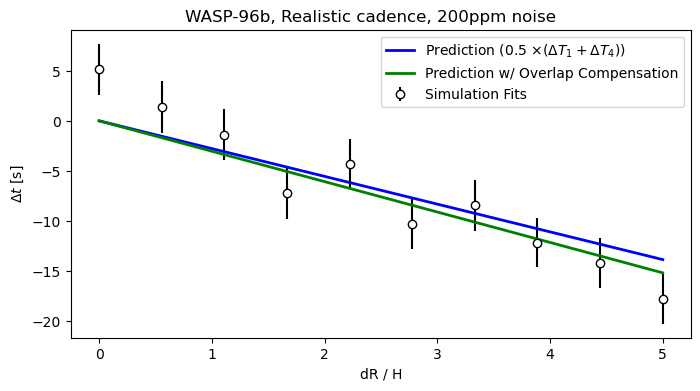

In [6]:
## -- WASP-96b 
## simulation results
w96_file = './newresults_realcadence_150ppmnoise_wasp96b_uniformLD.npz'
w96_load = np.load(w96_file)
w96_Nvals = w96_load['Nvals']
w96_Hval = w96_load['Hval'] # scale height in [meter]
w96_time = w96_load['time_axis']
w96_true_lightcurves = w96_load['true_lightcurves']
w96_bestfit_lightcurves = w96_load['bestfit_lightcurves']
w96_dt_fits = w96_load['dt_fits']
w96_dt_errs = w96_load['dt_fiterrs']
## planet parameters
w96_period_days = 3.4252565 # [day]
w96_a_Rstar = 9.03         # [stellar (wasp-39) radii]
w96_inc_deg = 85.6         # [degrees]
w96_Rstar_Rsol = 1.15    # [Rsun]
w96_Rstar_meter = w96_Rstar_Rsol * Rsun_to_meter # [meter]
w96_a_meter = w96_a_Rstar * w96_Rstar_Rsol * Rsun_to_meter
w96_impactparam = calc_impact_param(w96_a_Rstar, w96_inc_deg) # [unitless]
w96_Rpref_meter = 0.1186 * w96_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
w96_Rpeve_vals_meter = w96_Rpref_meter*np.ones(len(w96_Nvals))
w96_dR_vals_meter = w96_Nvals * w96_Hval
w96_Rpmorn_vals_meter = w96_Rpeve_vals_meter + w96_dR_vals_meter
w96_Rpunif_vals_meter = np.sqrt(0.5*(w96_Rpeve_vals_meter**2 + w96_Rpmorn_vals_meter**2))
w96_vorb = (2.*np.pi*w96_a_meter) / (w96_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
w96_predicted_dT1self_vals_sec = predict_dT1(w96_period_days, w96_a_meter, w96_impactparam, w96_Rstar_meter, w96_Rpmorn_vals_meter, w96_Rpeve_vals_meter)*day_to_second
w96_predicted_dT4self_vals_sec = predict_dT4(w96_period_days, w96_a_meter, w96_impactparam, w96_Rstar_meter, w96_Rpeve_vals_meter, w96_Rpeve_vals_meter)*day_to_second
w96_predicted_dT1ucase_vals_sec = predict_dT1(w96_period_days, w96_a_meter, w96_impactparam, w96_Rstar_meter, w96_Rpmorn_vals_meter, w96_Rpunif_vals_meter)*day_to_second
w96_predicted_dT4ucase_vals_sec = predict_dT4(w96_period_days, w96_a_meter, w96_impactparam, w96_Rstar_meter, w96_Rpeve_vals_meter, w96_Rpunif_vals_meter)*day_to_second
w96_predicted_dt = -0.5*(w96_predicted_dT1ucase_vals_sec+w96_predicted_dT4ucase_vals_sec)
w96_overlapcomp_sec = 0.5*overlap_compensation(w96_Rpref_meter, (w96_Rpref_meter/w96_Rstar_meter), w96_Hval, w96_Nvals, w96_vorb)
w96_overlapcomp_sec -= w96_overlapcomp_sec[0]

## plot results
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('WASP-96b, Realistic cadence, 200ppm noise',y=0.93)
ax.errorbar(w96_Nvals, w96_dt_fits, w96_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(w96_Nvals, w96_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(w96_Nvals, w96_predicted_dt-w96_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

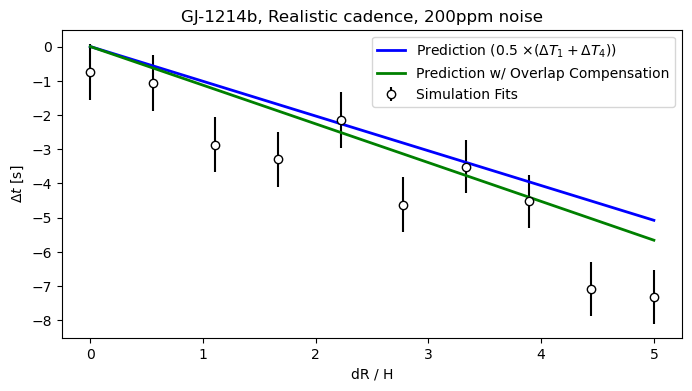

In [7]:
## -- WASP-107b 
## simulation results
g1214_file = './newresults_realcadence_200ppmnoise_gj1214b_uniformLD.npz'
g1214_load = np.load(g1214_file)
g1214_Nvals = g1214_load['Nvals']
g1214_Hval = g1214_load['Hval'] # scale height in [meter]
g1214_time = g1214_load['time_axis']
g1214_true_lightcurves = g1214_load['true_lightcurves']
g1214_bestfit_lightcurves = g1214_load['bestfit_lightcurves']
g1214_dt_fits = g1214_load['dt_fits']
g1214_dt_errs = g1214_load['dt_fiterrs']
## planet parameters
g1214_period_days = 1.58040433 # [day]
g1214_a_Rstar = 14.85         # [stellar (wasp-39) radii]
g1214_inc_deg = 88.7         # [degrees]
g1214_Rstar_Rsol = 0.215    # [Rsun]
g1214_Rstar_meter = g1214_Rstar_Rsol * Rsun_to_meter # [meter]
g1214_a_meter = g1214_a_Rstar * g1214_Rstar_Rsol * Rsun_to_meter
g1214_impactparam = calc_impact_param(g1214_a_Rstar, g1214_inc_deg) # [unitless]
g1214_Rpref_meter = 0.1160 * g1214_Rstar_Rsol * Rsun_to_meter # [meters], this is the 'starting' radius for the evening-limb radii values
g1214_Rpeve_vals_meter = g1214_Rpref_meter*np.ones(len(g1214_Nvals))
g1214_dR_vals_meter = g1214_Nvals * g1214_Hval
g1214_Rpmorn_vals_meter = g1214_Rpeve_vals_meter + g1214_dR_vals_meter
g1214_Rpunif_vals_meter = np.sqrt(0.5*(g1214_Rpeve_vals_meter**2 + g1214_Rpmorn_vals_meter**2))
g1214_vorb = (2.*np.pi*g1214_a_meter) / (g1214_period_days*24.*60.*60.) # [m/s]
## calculate analytic stuff to compare
g1214_predicted_dT1self_vals_sec = predict_dT1(g1214_period_days, g1214_a_meter, g1214_impactparam, g1214_Rstar_meter, g1214_Rpmorn_vals_meter, g1214_Rpeve_vals_meter)*day_to_second
g1214_predicted_dT4self_vals_sec = predict_dT4(g1214_period_days, g1214_a_meter, g1214_impactparam, g1214_Rstar_meter, g1214_Rpeve_vals_meter, g1214_Rpeve_vals_meter)*day_to_second
g1214_predicted_dT1ucase_vals_sec = predict_dT1(g1214_period_days, g1214_a_meter, g1214_impactparam, g1214_Rstar_meter, g1214_Rpmorn_vals_meter, g1214_Rpunif_vals_meter)*day_to_second
g1214_predicted_dT4ucase_vals_sec = predict_dT4(g1214_period_days, g1214_a_meter, g1214_impactparam, g1214_Rstar_meter, g1214_Rpeve_vals_meter, g1214_Rpunif_vals_meter)*day_to_second
g1214_predicted_dt = -0.5*(g1214_predicted_dT1ucase_vals_sec+g1214_predicted_dT4ucase_vals_sec)
g1214_overlapcomp_sec = 0.5*overlap_compensation(g1214_Rpref_meter, (g1214_Rpref_meter/g1214_Rstar_meter), g1214_Hval, g1214_Nvals, g1214_vorb)
g1214_overlapcomp_sec -= g1214_overlapcomp_sec[0]

## plot results
fig, ax = plt.subplots(figsize=(8,4))
fig.suptitle('GJ-1214b, Realistic cadence, 200ppm noise',y=0.93)
ax.errorbar(g1214_Nvals, g1214_dt_fits, g1214_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Fits')
ax.plot(g1214_Nvals, g1214_predicted_dt, lw=2, c='blue', label=r'Prediction (0.5 $\times \left( \Delta T_1 + \Delta T_4\right)$)')
ax.plot(g1214_Nvals, g1214_predicted_dt-g1214_overlapcomp_sec, lw=2, c='green', label='Prediction w/ Overlap Compensation')
ax.set(xlabel='dR / H', ylabel=r'$\Delta t$ [s]')
ax.legend(loc='best')
plt.show()

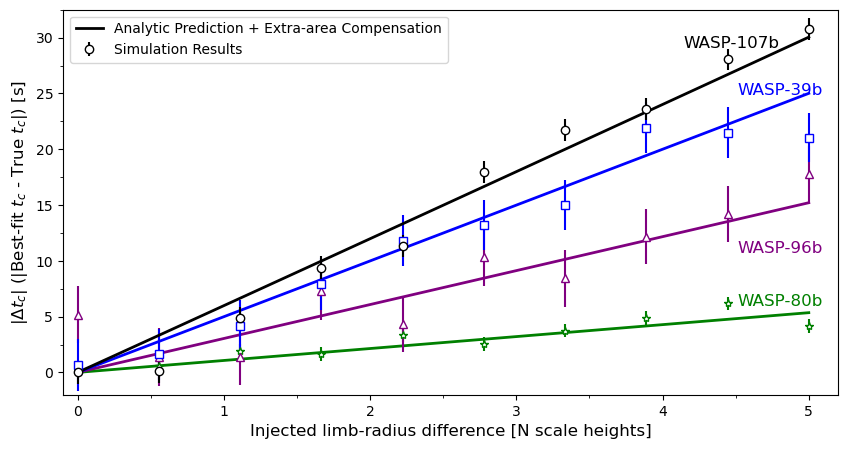

In [14]:
## -- plotting all planets together
## everything
fig, ax = plt.subplots(figsize=(10,5))
#ax.text(0.05, 0.8, 'Scatter = 200 ppm', transform=ax.transAxes)
ax.set_xlabel('Injected limb-radius difference [N scale heights]', fontsize=12)
ax.set_ylabel(r'|$\Delta t_c$| (|Best-fit $t_c$ - True $t_c$|) [s]', fontsize=12)
# wasp-80b
ax.errorbar(w80_Nvals, abs(w80_dt_fits), w80_dt_errs, marker='*', ls='None', c='green', mfc='white')
ax.plot(w80_Nvals, abs(w80_predicted_dt-w80_overlapcomp_sec), lw=2, c='green')
ax.text(0.87, 0.23, 'WASP-80b', c='green', fontsize=12, transform=ax.transAxes)
# wasp-96b
## NOTE THAT THIS IS 150 PPM SCATTER AND HALF REAL CADENCE
ax.errorbar(w96_Nvals, abs(w96_dt_fits), w96_dt_errs, marker='^', ls='None', c='purple', mfc='white')
ax.plot(w96_Nvals, abs(w96_predicted_dt-w96_overlapcomp_sec), lw=2, c='purple')
ax.text(0.87, 0.37, 'WASP-96b', c='purple', fontsize=12, transform=ax.transAxes)
# wasp-39b
ax.errorbar(w39_Nvals, abs(w39_dt_fits), w39_dt_errs, marker='s', ls='None', c='blue', mfc='white')
ax.plot(w39_Nvals, abs(w39_predicted_dt-w39_overlapcomp_sec), lw=2, c='blue')
ax.text(0.87, 0.78, 'WASP-39b', c='blue', fontsize=12, transform=ax.transAxes)
# wasp-107b
ax.errorbar(w107_Nvals, abs(w107_dt_fits), w107_dt_errs, marker='o', ls='None', c='black', mfc='white', label='Simulation Results')
ax.plot(w107_Nvals, abs(w107_predicted_dt-w107_overlapcomp_sec), lw=2, c='black', label='Analytic Prediction + Extra-area Compensation')
ax.text(0.8, 0.9, 'WASP-107b', c='black', fontsize=12, transform=ax.transAxes)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.set(ylim=(-2,32.5), xlim=(-0.1, 5.2))
ax.legend(loc='upper left')

plt.savefig('./paper_figures/realLCs_fitvstruth_tcbias.png', dpi=450, bbox_inches='tight')
plt.savefig('./paper_figures/realLCs_fitvstruth_tcbias.pdf', dpi=450, format='pdf', bbox_inches='tight')
plt.show()

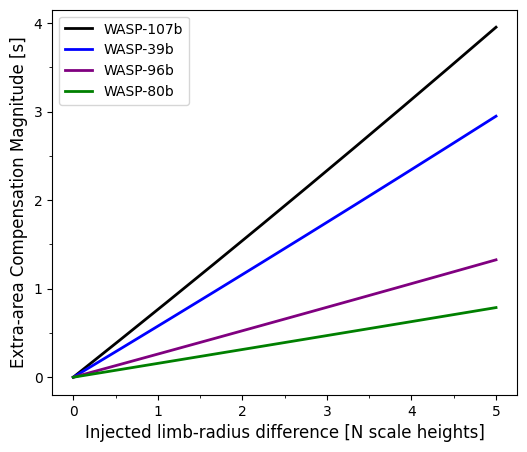

In [38]:
## -- plotting all planets together
## extra area compensations
fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel('Injected limb-radius difference [N scale heights]', fontsize=12)
ax.set_ylabel(r'Extra-area Compensation Magnitude [s]', fontsize=12)
# wasp-107b
ax.plot(w107_Nvals, abs(w107_overlapcomp_sec), lw=2, c='black', label='WASP-107b')
#ax.text(0.7, 0.8, 'WASP-107b', c='black', fontsize=12, transform=ax.transAxes)
# wasp-39b
ax.plot(w39_Nvals, abs(w39_overlapcomp_sec), lw=2, c='blue', label='WASP-39b')
#ax.text(0.9, 0.75, 'WASP-39b', c='blue', fontsize=12, transform=ax.transAxes)
# wasp-96b
ax.plot(w96_Nvals, abs(w96_overlapcomp_sec), lw=2, c='purple', label='WASP-96b')
#ax.text(0.9, 0.4, 'WASP-96b', c='purple', fontsize=12, transform=ax.transAxes)
# wasp-80b
ax.plot(w80_Nvals, abs(w80_overlapcomp_sec), lw=2, c='green', label='WASP-80b')
#ax.text(0.9, 0.25, 'WASP-80b', c='green', fontsize=12, transform=ax.transAxes)

ax.legend(loc='upper left')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

plt.savefig('./paper_figures/realLCs_compensationmagnitudes.png', dpi=450, bbox_inches='tight')
plt.savefig('./paper_figures/realLCs_compensationmagnitudes.pdf', format='pdf', dpi=450, bbox_inches='tight')
plt.show()

# ## and their slopes
# slope_w107, ipt_w107 = np.polyfit(w107_Nvals, abs(w107_overlapcomp_sec), deg=1)
# slope_w39, ipt_w39 = np.polyfit(w39_Nvals, abs(w39_overlapcomp_sec), deg=1)
# slope_w96, ipt_w96 = np.polyfit(w96_Nvals, abs(w96_overlapcomp_sec), deg=1)
# slope_w80, ipt_w80 = np.polyfit(w80_Nvals, abs(w80_overlapcomp_sec), deg=1)

# Harray = np.array([w80_Hval, w96_Hval, w39_Hval, w107_Hval])
# slopearray = np.array([slope_w80, slope_w96, slope_w39, slope_w107])

# fig, ax = plt.subplots(figsize=(8,5))
# ax.plot(Harray/1000., slopearray, c='black', marker='o')
# ax.set_ylabel('Slope of E-a C. M.')
# ax.set_xlabel('Scale height [km]')
# plt.show()

Looking at the "perfect case" based on WASP-39b parameters to evaluate how the overall theory stacks up.

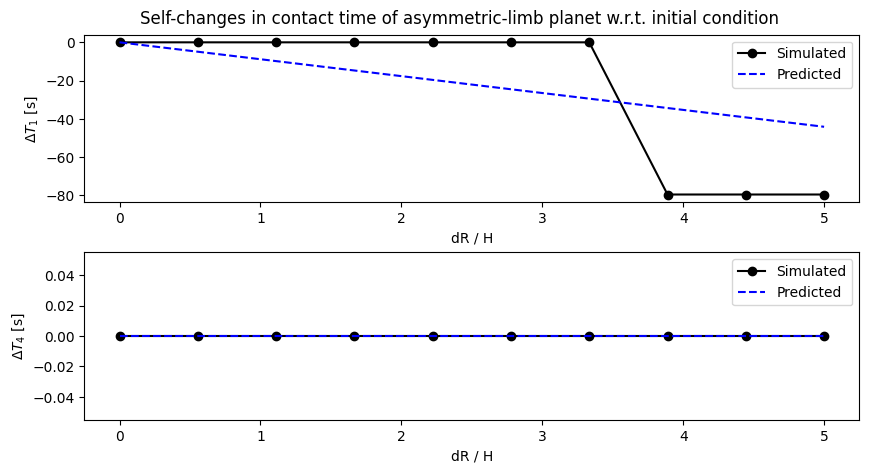

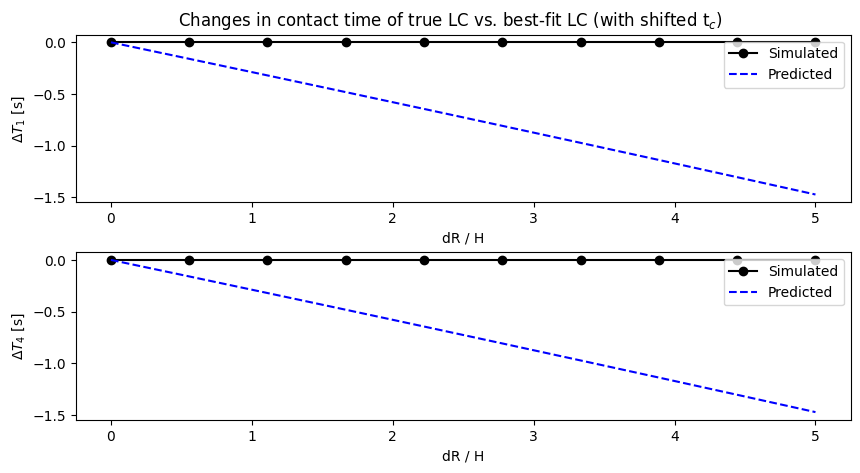

In [10]:
## -- track how T1 and T4 changed in the numerical sim's true light curves
## -- this assumes that the first light curve is a reference, and has N = 0
day_to_second = 60.*60.*24.

T1_fromtrueLCs = np.zeros(len(w39_Nvals)) 
T4_fromtrueLCs = np.zeros(len(w39_Nvals))
T1_frombfLCs = np.zeros(len(w39_Nvals)) 
T4_frombfLCs = np.zeros(len(w39_Nvals))
for iN, N in enumerate(w39_Nvals):
    # numerically determine T1 and T4 of each "true" lightcurve
    T1_fromtrueLCs[iN] = w39_time[get_T1_index(w39_time, w39_true_lightcurves[iN,:])] # [day]
    T4_fromtrueLCs[iN] = w39_time[get_T4_index(w39_time, w39_true_lightcurves[iN,:])] # [day]
    # numerically determine T1 and T4 of each best-fit lightcurve
    T1_frombfLCs[iN] = w39_time[get_T1_index(w39_time, w39_bestfit_lightcurves[iN,:])] # [day]
    T4_frombfLCs[iN] = w39_time[get_T4_index(w39_time, w39_bestfit_lightcurves[iN,:])] # [day]
# calculate change in T1 and T4 just of asymmetric-limb planet w.r.t initial state, assuming first value in arrays are the reference
dT1_fromtrueLCs = (T1_fromtrueLCs - T1_fromtrueLCs[0]) # [day]
dT4_fromtrueLCs = (T4_fromtrueLCs - T4_fromtrueLCs[0]) # [day]
# calculate change in T1 and T4 btwn. asymmetric-limb planet LC (truth) and the best-fit equiv. uniform-limb planet (with shifted Tc)
#       as function of asymmetry increasing. shouldn't follow analytic prediction! should be small, but non-zero
dT1_bf_from_true = (T1_frombfLCs - T1_fromtrueLCs) # [day]
dT4_bf_from_true = (T4_frombfLCs - T4_fromtrueLCs) # [day]

# plot these changes
# note these are NOT changes in T1, T4 btwn. asym-limb planet and the equivalent planet
# these are changes in T1, T4 just for the asym-limb planet w.r.t. the starting case as the asymmetry increases
fig, ax = plt.subplots(figsize=(10,5), nrows=2)
fig.suptitle('Self-changes in contact time of asymmetric-limb planet w.r.t. initial condition', y=0.93)
plt.subplots_adjust(hspace=0.3)
ax[0].plot(w39_Nvals, dT1_fromtrueLCs*day_to_second, marker='o', c='black', label='Simulated')
ax[0].plot(w39_Nvals, -w39_predicted_dT1self_vals_sec, c='blue', ls='--', label='Predicted')
ax[0].set_ylabel('$\Delta T_1$ [s]')
ax[0].set_xlabel('dR / H')
ax[0].legend(loc='upper right')
ax[1].plot(w39_Nvals, dT4_fromtrueLCs*day_to_second, marker='o', c='black', label='Simulated')
ax[1].plot(w39_Nvals, -w39_predicted_dT4self_vals_sec, c='blue', ls='--', label='Predicted')
ax[1].set_ylabel('$\Delta T_4$ [s]')
ax[1].set_xlabel('dR / H')
ax[1].legend(loc='upper right')
plt.show()


## -- note the following is NOT to be compared to analytical prediction b/c it involves the uniform-limb
#  results with a shifted tc, not the same tc as the true asym-limb model
fig, ax = plt.subplots(figsize=(10,5), nrows=2)
fig.suptitle('Changes in contact time of true LC vs. best-fit LC (with shifted t$_c$)', y=0.93)
plt.subplots_adjust(hspace=0.3)
ax[0].plot(w39_Nvals, dT1_bf_from_true*day_to_second, marker='o', c='black', label='Simulated')
ax[0].plot(w39_Nvals, -0.5*w39_overlapcomp_sec, c='blue', ls='--', label='Predicted')
ax[0].set_ylabel('$\Delta T_1$ [s]')
ax[0].set_xlabel('dR / H')
ax[0].legend(loc='upper right')
ax[1].plot(w39_Nvals, dT4_bf_from_true*day_to_second, marker='o', c='black', label='Simulated')
ax[1].plot(w39_Nvals, -0.5*w39_overlapcomp_sec, c='blue', ls='--', label='Predicted')
ax[1].set_ylabel('$\Delta T_4$ [s]')
ax[1].set_xlabel('dR / H')
ax[1].legend(loc='upper right')
plt.show()

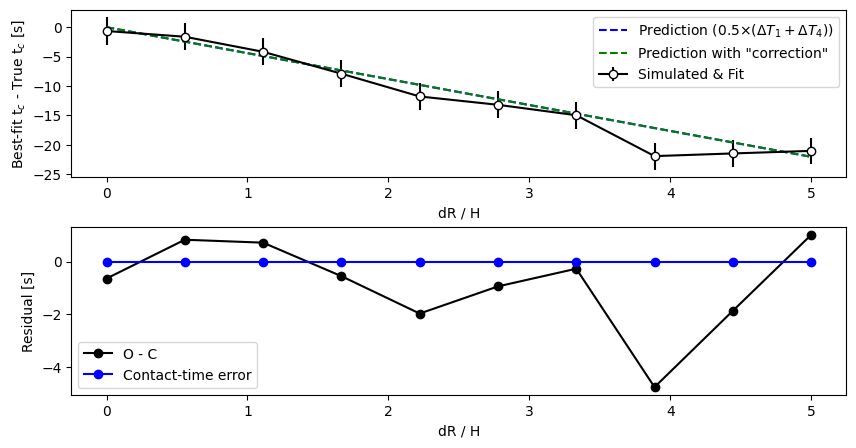

In [11]:
## -- see the best-fit timing bias
dt_prediction = -0.5*(w39_predicted_dT1ucase_vals_sec + w39_predicted_dT4ucase_vals_sec)
O_minus_C = (w39_dt_fits - dt_prediction)
contact_err_correction = np.median((dT1_bf_from_true, dT4_bf_from_true), axis=0) * day_to_second

fig, ax = plt.subplots(figsize=(10,5), nrows=2)
plt.subplots_adjust(hspace=0.3)
ax[0].errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', c='black', mfc='white', label='Simulated & Fit')
ax[0].plot(w39_Nvals, dt_prediction, c='blue', ls='--', label=r'Prediction (0.5$\times \left( \Delta T_1 + \Delta T_4 \right)$)')
ax[0].plot(w39_Nvals, dt_prediction+contact_err_correction, c='green', ls='--', label=r'Prediction with "correction"')
ax[0].set_xlabel('dR / H')
ax[0].set_ylabel('Best-fit t$_c$ - True t$_c$ [s]')
ax[0].legend(loc='best')
ax[1].plot(w39_Nvals, O_minus_C, marker='o', c='black', label='O - C')
ax[1].plot(w39_Nvals, contact_err_correction, marker='o', c='blue', label='Contact-time error')
ax[1].set_xlabel('dR / H')
ax[1].set_ylabel('Residual [s]')
ax[1].legend(loc='best')
plt.show()

In [12]:
print('N       dt fit')
for iN, N in enumerate(w39_Nvals):
    print('%.2f    %.2f'%(N, w39_dt_fits[iN]))

N       dt fit
0.00    -0.64
0.56    -1.62
1.11    -4.18
1.67    -7.91
2.22    -11.79
2.78    -13.20
3.33    -14.98
3.89    -21.94
4.44    -21.48
5.00    -21.04


In [13]:
## -- why is there a contact time error ???


In [14]:
# hypothesis 1 -- the batman model can't get the right transit duration
# define transit duration as T4 - T1, with T1,T4 determined via my functions
true_durations = (T4_fromtrueLCs - T1_fromtrueLCs)*day_to_second # in [s]
batman_durations = (T4_frombfLCs - T1_frombfLCs)*day_to_second # in [s]
duration_diffs = (batman_durations - true_durations)

for iN, N in enumerate(w39_Nvals):
    print('='*20)
    print('N = %.2f'%(N))
    print('true duration = %.2f s'%(true_durations[iN]))
    print('fitted LC duration = %.2f s'%(batman_durations[iN]))
    print(' fitted value is %.2f s behind truth'%(duration_diffs[iN]))
    print(' predicted error here was %.2f s behind truth'%(-contact_err_correction[iN]))

N = 0.00
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 0.56
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 1.11
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 1.67
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 2.22
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 2.78
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind truth
 predicted error here was -0.00 s behind truth
N = 3.33
true duration = 9858.00 s
fitted LC duration = 9858.00 s
 fitted value is 0.00 s behind tru

In [15]:
# hypothesis 2 -- it has to do with the shapes of ingress/egress, and our fitting metrics
#   the asymmetric-limb models have a "notch" during ingress and egress due to the way the occulting
#       area "jumps" as the second semi-circle makes first contact
#   the uniform-limb model does not have this
#   I hypothesize that this notch throws off some fitting metric, e.g. the chi2 calculation in the likelihood
#      forcing it to find a slightly alternate solution that prioritizes minimizing the chi2 (or residual)
#      rather than getting the right start/end of transit


In [16]:
# fig, ax = plt.subplots(figsize=(10,10), nrows=2, sharex=True)
# plt.subplots_adjust(hspace=0.1)
# day_to_second = 24.*60.*60.
# iLC = 4
# this_T1 = T1_fromtrueLCs[iLC]*day_to_second
# this_bfT1 = T1_frombfLCs[iLC]*day_to_second
# ws = 30.
# voffset = 0.00025


# ax[0].axvline(this_T1, c='gray', lw=0.5, label=r'T$_{1, true~lc}$')
# ax[0].axvline(this_bfT1, c='green', lw=0.5, label=r'$T_{1, bf~lc}$')
# #ax[0].axvline(this_T1-6.0, c='blue', lw=0.5)
# ax[0].plot(w39_time*day_to_second, w39_true_lightcurves[iLC,:], lw=1, c='black', label='Truth (a.l. model)')
# #ax[0].plot(w39_time*day_to_second, w39_bestfit_lightcurves[iLC,:]+voffset, lw=0.5, c='green', label='Best-fit u.l. model')
# ax[0].set(ylabel='Relative flux', xlabel='Time')
# ax[0].legend(loc='best')

# bf_min_true =  (w39_bestfit_lightcurves[iLC,:] - w39_true_lightcurves[iLC,:])*1.e6
# ax[1].axvline(this_T1, c='gray', lw=0.5, label=r'T$_{1, true~lc}$')
# ax[1].axvline(this_bfT1, c='green', lw=0.5, label=r'$T_{1, bf~lc}$')
# ax[1].axvline(this_T1-5.0, c='blue', lw=0.5)
# ax[1].plot(w39_time*day_to_second, bf_min_true, c='black')
# ax[1].set(ylabel='O-C [ppm]', xlabel='Time')
# ax[1].legend(loc='best')

# #ax[0].set(ylim=(999.5, 1000.1))
# ax[1].set(xlim=(this_T1-ws, this_T1+ws), ylim=(-40,10))
# plt.show()

# print('mean residual = ', np.mean(bf_min_true))

In [17]:
## hyp3


In [18]:
# define p = Rp/Rstar
p = w39_Rpref_meter / w39_Rstar_meter
xRp = w39_Rpref_meter


xtests = (xRp + (w39_Nvals*w39_Hval))#/xRp
y = (xRp/p) - np.sqrt((xRp/p)**2 - xtests**2) # [meter]

#y_s = y/v # [s]

y_s = overlap_compensation(xRp, p, w39_Hval, w39_Nvals, v)
print(y_s-y_s[0])

NameError: name 'v' is not defined

In [ ]:
## -- see the best-fit timing bias
dt_prediction = -0.5*(w39_predicted_dT1ucase_vals_sec + w39_predicted_dT4ucase_vals_sec)
overlap_comp = -0.5*(y_s - y_s[0]) # not sure why this needs to be halved ...

O_minus_C = (w39_dt_fits - dt_prediction)
O_minus_C_withcomp = (w39_dt_fits - (dt_prediction+overlap_comp))

fig, ax = plt.subplots(figsize=(10,5), nrows=2)
plt.subplots_adjust(hspace=0.3)
ax[0].errorbar(w39_Nvals, w39_dt_fits, w39_dt_errs, marker='o', c='black', mfc='white', label='Simulated & Fit')
ax[0].plot(w39_Nvals, dt_prediction, c='blue', ls='--', label=r'Prediction (0.5$\times \left( \Delta T_1 + \Delta T_4 \right)$)')
ax[0].plot(w39_Nvals, dt_prediction+overlap_comp, c='green', ls='--', label=r'Prediction + compensation')
ax[0].set_xlabel('dR / H')
ax[0].set_ylabel('Best-fit t$_c$ - True t$_c$ [s]')
ax[0].legend(loc='best')
ax[1].plot(w39_Nvals, O_minus_C, marker='o', c='black', label='O - C')
ax[1].plot(w39_Nvals, O_minus_C_withcomp, marker='o', c='blue', label='Contact-time error')
ax[1].set_xlabel('dR / H')
ax[1].set_ylabel('Residual [s]')
ax[1].legend(loc='best')
plt.show()

In [ ]:
## note -- need to consider how to describe this "correction"
##  I think it's not an err to the formula, but rather a difference between the theory and what can be done in practice
##   i.e. we may be predicting the right thing, but through the models and *fitting* these models, the *thing* we measure
##      as our "best-fit" result is a different *quantity* than what our theory is making predictions on
##    and this "correction" is an idea for the difference between them, which seems to get fairly close.
##  Our theory predicts what dt is needed to get the contact points to rematch
##    because we're measuring goodness-of-fit by some metric related to minimized residuals, and the models have intrinsically
##    different shapes ... this dt is not necessarily the dt that will provide the best goodness-of-fit
##    and this correction is an attempt at explaining, and "un-doing" the way that it strays
##  This solution posits that the fit gets "led astray" b/c it compensates for the increased residual due to this overlap problem
##    and this "correction" is just a formulation of the time difference caused by this overlap, which the fit is adding on to itself
##    so by either adding this onto the theory prediction, or subtracting from the fit, we bring theory and fit into agreement.